# Content-Based Filtering: NLP Based Book Recommender Using BERT-Embeddings

In [ ]:
__author__ = "Amoli Rajgor"
__email__ = "amoli.rajgor@gmail.com"
__website__ = "amolir.github.io"

# Introduction
- Content based filtering is one of the two common techniques of recommender systems. intelligible from the name, it uses the content of the entity (to be recommended) to find other relevant recommendations similar to it. In simpler terms the system finds the keywords or attributes related to the product that the user likes, later uses this information to recommend other products having similar attributes. 
- For a book recommendation system, given a book name the recommender will suggest books that are similar to it. The choice is made considering concise information of the book such as its theme, author, series, and summary of the description. 

## Book Recommendation System
- The succinct data of keywords that is provided to the recommender system is generated using NLP techniques such as word embeddings.  Keywords that most describe the book are extracted from the book description using BERT-embeddings, this word collection is further reduced using the frequentist feature extraction method TF-IDF that ranks the words based on their frequency in the book and the corpus.     
- Once the numeric vector representation of all the books is generated, each word vector is compared against the other vector and similar vectors (books) are found using cosine similarity.  
   

![architecture](../images/book_recommendation_system.svg)

---
# Environment and Project Flow
- The project pipeline is divided into three stages: <br/>

[![Open Notebook](https://img.shields.io/badge/Jupyter-Open_Notebook-blue?logo=Jupyter)](eda.ipynb) **Cleaning** <br/>
[![Open Notebook](https://img.shields.io/badge/Jupyter-Open_Notebook-blue?logo=Jupyter)](feature_engineering.ipynb) **Feature Extraction** <br/>
[![Open Notebook](https://img.shields.io/badge/Jupyter-Open_Notebook-blue?logo=Jupyter)](model.ipynb) **Modeling** <br/>

- There’s a dedicated notebook for each of these stages containing detailed implementation of all intermediate steps. At the end of each stage the processed data is stored in the form of a CSV file. Current book will serve as a summarised representation of the project.
- I will be using the following list of packages for the project.
> <h4 style="color:blue"> ℹ️ Dependencies </h4> <div style="background-color:#dbeaff">  &#10148; numpy &ge; 1.22.3 <br> &#10148; pandas &ge; 1.4.1 <br> &#10148; scikit-learn &ge; 1.0.2 <br> &#10148; keybert &ge; 0.5.1 <br> &#10148; nltk &ge; 3.5 <br> &#10148; matplotlib &ge; 3.5.1 <br> &#10148; altair &ge; 4.2.0 <br> &#10148; dask  &ge; 2022.4.1 <br> </div>

## Usage Instructions
- Simply run `pip install requirements.txt` from the terminal to install all the dependencies before running the notebook.    
- Download the [data](https://www.kaggle.com/datasets/bahramjannesarr/goodreads-book-datasets-10m?select=book1000k-1100k.csv), rename it to "goodreads_book.csv". Create a folder named `data` and place the downloaded _.csv_ file inside it.
- All the intermediate transformed dataset (`preprocessed.csv` and `keywords.csv`) will be stored in the `data` folder itself.
- Either run the notebooks in the sequence `eda.ipybn` -> `feature_engineering.ipynb` -> `model.ipynb` to generate results.
- Or uncomment the code to save result to csv, in this notebook.

In [1]:
# Data Manipulation
import pandas as pd
import numpy as np

# RegEx and String Manipulation
import re
import string

# Language Detection
from nltk.classify.textcat import TextCat

# Multiprocessing
import dask.dataframe as dd
import multiprocessing

# BERT-Embeddings
from keybert import KeyBERT

# TF-IDF Vectorization
from sklearn.feature_extraction.text import TfidfVectorizer

# Plotting Heatmap of TF-IDF vectors 
import matplotlib.pyplot as plt
import altair as alt
alt.renderers.enable('mimetype')

# Cosine Similarity
from sklearn.metrics.pairwise import cosine_similarity

In [11]:
# Minimum number of words that should be present in a description (value starting from 1)
min_description_word_count = 3

---
---
# Data
- Dataset used for this project can be found [here](https://www.kaggle.com/datasets/bahramjannesarr/goodreads-book-datasets-10m?select=book1000k-1100k.csv). It is a [Goodreads](https://www.goodreads.com/) book  dataset containing book details and user rating of 10M books. As I am creating a POC project I will only be using data of 39705 books. It contains information such as book name, authors, publishers, publishing year, rating, description, review count, page number etc. I will only use the content that is needed to extract the book summary keywords.

In [12]:
books_data = pd.read_csv("data/goodreads_book.csv", usecols=['Id', 'Name', 'Authors', 'ISBN', 'PublishYear', 'Publisher', 'Language', 'Description'])
display(books_data.shape)
books_data.head(5)

(39705, 8)

,Id,Name,Authors,ISBN,PublishYear,Publisher,Language,Description
0,1000000,Flight from Eden,Kathryn A. Graham,0595199402,2001,Writer's Showcase Press,NaN,"What could a computer expert, a mercenary with..."
1,1000001,Roommates Again,Kathryn O. Galbraith,0689505973,1994,Margaret K. McElderry Books,NaN,"During their stay at Camp Sleep-Away, sisters ..."
2,1000003,The King At The Door,Brock Cole,0374440417,1992,Farrar Straus Giroux,NaN,A poorly dressed old man appears at an inn and...
3,1000004,"Giotto: The Scrovegni Chapel, Padua",Bruce Cole,080761310X,1993,George Braziller,NaN,This beautiful series lavishly illustrates the...
4,1000005,Larky Mavis,Brock Cole,0374343659,2001,"Farrar, Straus and Giroux (BYR)",NaN,<b>Another orginal picture-book fairy tale</b>...


---
---
# Text Cleaning
<span style="font-size:1.5em;">Notebook:</span> [<span style="font-size:1.5em;">eda.ipynb</span>](eda.ipynb)

Text cleaning in NLP is the process of transforming the textual data into a format that is machine readable. Cleaning of the data is required to reduce the complexity of the model and increase its accuracy. We want to avoid processing irrelevant words and want the model to give equal weightage to the same words in spite of punctuations, letter case etc. Let's apply following steps to clean various features before performing keyword extraction onto it. Data is already processed ([Check eda.ipynb](eda.ipynb)) using these steps and results are store in `data/preprocessed.csv`.

##  Remove books with Missing Description
**Description** of the book becomes content for the recommendation engine. We want to extract keywords from the description of the book in such a case books with no description won’t add value to the model. However to avoid information loss in real scenario, missing descriptions can be filled with empty strings.

In [13]:
books_data.dropna(subset=["Description"], inplace=True)

## Remove URLs and HTML Tags and Punctuations from the Description.
**Description** feature contains URLs, HTML tags and punctuations (example below). Let’s remove all this irrelevant textual information to refine it. 

In [14]:
list(books_data.Description[books_data.Id == 1099555]) #Description with url and html tag

['<i>Alternate Cover Edition can be found <a href="https://www.goodreads.com/book/show/38559855" rel="nofollow">here</a></i><br /><br />Das Böse hält keinen Winterschlaf.<br />Kathy Reichs auch nicht.<br /><br /><br />Was könnte frostiger sein als ein kanadischer Dezembersturm? Tempe Brennan, forensische Anthropologin in Montreal, wird an einem tristen Montagmorgen zu einem Fundort gerufen, der ihr das Blut in den Adern gefrieren lässt. Verscharrt in einem Kellergewölbe liegen die Leichen dreier junger Frauen. Nicht eine Gewebefaser, kein Fetzen Kleidung geben Aufschluss darüber, wann und warum diese Mädchen sterben mussten. Nur dank akribischer Ermittlungen und weiblicher Intuition kommt Tempe dem Mörder auf die Spur. Doch sie muss auf alles gefasst sein, denn ihr Gegner ist an Kaltblütigkeit nicht zu übertreffen …<br /><br /><br />Tempe Brennans siebter Fall.<br /><br /><br /><br /><br />']

In [15]:
url_pattern = re.compile(r'https?://\S+|www\.\S+')
def remove_url(text):   
    return re.sub(url_pattern, r'', text)

html_pattern = re.compile('<[^>]*>')
def clean_html_tags(text):
    return re.sub(html_pattern, r'', text)

punctuations = string.punctuation
def remove_punctuations(text):
    return text.translate(str.maketrans('', '', punctuations))

books_data.Description = books_data.Description.apply(remove_url)
books_data.Description = books_data.Description.apply(clean_html_tags)
books_data.Description = books_data.Description.apply(remove_punctuations)

# Result
list(books_data.Description[books_data.Id == 1099555])

['Alternate Cover Edition can be found hereDas Böse hält keinen WinterschlafKathy Reichs auch nichtWas könnte frostiger sein als ein kanadischer Dezembersturm Tempe Brennan forensische Anthropologin in Montreal wird an einem tristen Montagmorgen zu einem Fundort gerufen der ihr das Blut in den Adern gefrieren lässt Verscharrt in einem Kellergewölbe liegen die Leichen dreier junger Frauen Nicht eine Gewebefaser kein Fetzen Kleidung geben Aufschluss darüber wann und warum diese Mädchen sterben mussten Nur dank akribischer Ermittlungen und weiblicher Intuition kommt Tempe dem Mörder auf die Spur Doch sie muss auf alles gefasst sein denn ihr Gegner ist an Kaltblütigkeit nicht zu übertreffen …Tempe Brennans siebter Fall']

## Convert Letter Case to Lower and Clip Extra Spaces
- Before changing the letter case, assign missing **Publisher** some temporary string `unknown` to retain these missing values during string transformation. 

In [16]:
books_data[["Publisher"]] = books_data[["Publisher"]].fillna("unknown")
books_data[["Name", "Authors", "Publisher", "Description"]] = pd.concat([books_data[col].astype(str).str.lower().str.strip() 
                                                                             for col in ["Name", "Authors", "Publisher", "Description"]], 
                                                                            axis=1)

## Remove Book Descriptions With Shorter Length.
After removing extra spaces it is found that some book descriptions only had blank spaces and really short descriptions containing one or two words. Such words do not retain the semantic meaning of the description and l will remove books with such shorter descriptions (word count less than four). We will first remove empty descriptions to `NaN` and then remove them.

In [17]:
# Find description word count
books_data["length"] = [len(d.split()) for d in books_data['Description'].tolist()]

print(set(books_data.Description[books_data.length.isin(range(0,4))]))

{'', 'edition bilingue', 'anthology', 'achtzehn beispielhafte bildergeschichten', 'level a', '《洗澡》不是由一个主角贯连全部的小说，而是借一个政治运动作背景，写那个时期形形色色的知识分子。所以是个横断面；既没有史诗性的结构，也没有主角。本书第一部写新中国不拘一格收罗的人才，人物一一出场。第二部写这些人确实需要“洗澡”。第三部写运动中这群人各自不同的表现。“洗澡”没有得到预期的效果，原因是谁都没有自觉自愿。假如说，人是有灵性、有良知的动物，那么，人生一世，无非是认识自己，洗炼自己，自觉自愿地改造自己，除非甘心与禽兽无异。但是这又谈何容易呢？这部小说里，只有一两人自觉自愿地试图超拔自己。读者出于喜爱，往往把他们看作主角。', 'the understanding', '《文化、權力與國家1900—1942年的華北農村》是美國學者杜贊奇的名著。杜贊奇（prasenjit duara），早年就學於印度，後赴美國求學，師從著名漢學大師孔飛力，現任美國芝加哥大學歷史學系及東亞語言文明系教授。其著作除本書外，還有廣為學界選舉的《從民族國家拯救歷史》。此兩書使杜贊奇成為名聞國際的漢學家。本書是以鄉村的文化網絡為基本結構並考察其功能力，作者主要利用日本南滿鐵道株式會社調查部編撰的《中國慣行調查報告》、南開大學經濟研究所在20世紀二三十年代所做的社會調查材料，以及中外學者已有的研究成果，通過細致的個案研究，向我們展示了1900—1942年間華北農村社會的政治經濟文化的一般狀況。作者力圖打通歷史學與社會學的間隔，提出了「國家政權建設」和「權力的文化網絡」兩個中心概念。作者認為，「國家政權建設」是一種全球性現象，作為一個概念，同更古老的「資本主義」等概念一樣，具有深遠的分析性含義。「權力的文化網絡」概念則吸收了西方學術界有關文化研究的成果，反對一些現代化論者用單一社會體系或一套所謂的「中國價值觀」去理解中國的觀點，同時也反對認為價值觀點交互感應的功能主義論者的學說。最重要的一點是，作者在書中貫穿了這樣一種方法在考慮話語—主體—制度這三者對歷史的建構時，應加入許多外來事物和偶然因素，因為參與主體和主體性構成的不僅有話語，還有外來事物；而由主體構建的制度，還應包括制度本身的邏輯性和偶然性。本書曾先後榮

In [18]:
# Replace empty strings of description with NaN
books_data.Description = books_data.Description.replace(r'^\s*$', np.nan, regex=True)

books_data[books_data.length.isin(range(1,min_description_word_count+1))][["Id", "Name", "Description", "length"]]\
.sort_values(by=["length"], ascending=True).head(5)

,Id,Name,Description,length
636,1001461,barbarism,poetry,1
24941,1062171,middlemarch: in half the time,abridged,1
17626,1043889,"to the nines (stephanie plum, #9)",1593977484,1
26421,1065801,the bird lovers,drama,1
26889,1066895,凤凰集,本集共收《在私塾》、《往事》、《常德的船》、《凤凰》等10篇散文。,1


In [19]:
books_data.dropna(subset=["Description"], inplace=True)

# Drop records with very short description
books_data.drop(books_data.index[books_data.length.isin(range(0,min_description_word_count+1))], inplace = True)
del books_data["length"]

## Drop Variants of the Same Book
- Descriptions are repeated; this possibly could be due to different versions of the same book. Repeated values in **Authors, Publisher** can help in recommending books of the same author and publisher.
- We see that the same books have different ISBN because an ISBN is assigned to each separate edition and variation of a publication. ISBN is like an identity number for each edition, imprint, impression or version of the same book. For example, an e-book, a paperback and a hardcover edition of the same book will each have a different ISBN (except reprintings).
- Only keep variants where **Publisher** is not null, if Publisher is missing for all the variants then keep the first occurrence and delete rest.

In [20]:
# Convert unknown to NaN
books_data["Publisher"] = books_data.Publisher.replace('unknown',np.nan)
books_data = books_data.sort_values(by="Publisher", na_position='last')\
.drop_duplicates(subset=["Name", "Authors", "Description"], keep='first')

Though we have deleted rows with the same **Name, Authors** and **Description**, we still find books having duplicated Description. This happens due to minor textual changes in the **Name** of the book and also because certain **Description**s are repetitive for different books.

## Extract and Remove Book Series Information from the Book Name
- Remove irrelevant information from the name of the book to improve efficiency of the tokenization.
- Book names with a hashtag following a number represents the edition of the book in a series. (Example: In book name blood captain (vampirates, #3), vampirates is the series name and #3 means its third book in the series.)


In [ ]:
series_pattern =  "(?:[;]\s*|\(\s*)([^\(;]*\s*#\s*\d+(?:\.?\d+|\\&\d+|-?\d*))"
def get_book_series_info(text):
    series_info = re.findall(series_pattern, text)
    if series_info:
        series_info = " ".join([i.replace(" ", "_") for i in series_info])
        return series_info
    else:
        return np.nan
    
books_data['BookSeriesInfo'] = books_data.Name.apply(get_book_series_info)

- As we are using regex there will be certain exceptions, for example it misses a book name with nested brackets case. The name of the book is "Ranma 1/2, Vol. 28 (Ranma ½ (US 2nd), #28)", it should extract series information as `Ranma ½ (US 2nd), #28]`, instead, it extracts `[US 2nd), #28]`

## Extract and Remove Book Series Information from the Book Name

In [23]:
series_remove_pattern = re.compile("(?:[\(]\s*[^\(;]*\s*#\s*\d+(?:\.?\d+|\\&\d+|-?\d*)(?:;|\))|\s*[^\(;]*\s*#\s*\d+(?:\.?\d+|\\&\d+|-?\d*)\))")       
def remove_series_info(text):
    return re.sub(series_remove_pattern, r'', text)

books_data["Title"]= books_data["Name"].str.replace(series_remove_pattern, r'').str.strip()

## Impute Missing Language Information Using the Language of the Book Name
**Language** feature has missing values. I will impute missing **Language** information using the language of the book **Name**. Language detection for thousands of records takes considerable time. I have already saved the results into a CSV `preprocessed.csv`. I will directly use that for further processing.

In [25]:
tc = TextCat()

def detect_language(text):
    text = " ".join(text.split()[:5])
    if text.isnumeric():
        return 'eng'
    else:
        return tc.guess_language(text).strip()

In [37]:
 """
 Takes longer time to process thousands records hence results are presaved in preprocessed.csv
 """
# ddf = dd.from_pandas(books_data, npartitions=4*multiprocessing.cpu_count()) 
# books_data["Language"] = ddf.map_partitions(lambda df: df.apply(lambda x: detect_language(x['Name']) if pd.isna(x['Language']) else x['Language'], axis=1)).compute() 
# books_data.isna().sum()

Id                    0
Name                  0
Authors               0
ISBN                 87
PublishYear           0
Publisher           228
Language              0
Description           0
BookSeriesInfo    32380
Title                 0
dtype: int64

In [28]:
temp_preview = books_data.head(5).copy()
ddf = dd.from_pandas(temp_preview, npartitions=4*multiprocessing.cpu_count()) 
temp_preview["Language"] = ddf.map_partitions(lambda df: df.apply(lambda x: detect_language(x['Name']) if pd.isna(x['Language']) else x['Language'], axis=1)).compute() 
temp_preview

,Id,Name,Authors,ISBN,PublishYear,Publisher,Language,Description,BookSeriesInfo,Title
8222,1020396,the gospel of john,francis j. moloney,0814658067,1998,"""michael glazier""",eng,what sets this commentary on the fourth gospel...,NaN,the gospel of john
29576,1073868,hanslick on the musically beautiful: sixteen l...,geoffrey payzant,1877275530,2003,1-877275-49-2,eng,the sixteen lectures by geoffrey payzant in th...,NaN,hanslick on the musically beautiful: sixteen l...
10277,1025976,microserfs,douglas coupland,2264024003,1997,10/18,fre,génération x 1018 n° 2508 qui a connu un gros ...,NaN,microserfs
18484,1045943,courir avec des ciseaux,augusten burroughs,2264043784,2006,10/18,fre,roman autobiographique choc courir avec des ci...,NaN,courir avec des ciseaux
11093,1027805,affinités,sarah waters,2264043628,2006,10/18,fre,pour tromper son ennui une demoiselle de la bo...,NaN,affinités


## Remove Double Quotes from Publisher Name.

In [29]:
books_data["Publisher"] = books_data["Publisher"].str.replace('"','')

## Transform Book and Author Names into Single Token
- Merge first and last name of authors (with `_`) so that two authors with same first or last name are not considered same when the tokenization happens.
- Also merge name of the book so that it is considered as single token during the processing.

In [32]:
books_data["Authors"] = books_data["Authors"].str.strip().str.replace(' ','_')
books_data["Publisher"] = books_data["Publisher"].str.strip().str.replace(' ','_')
books_data.head(5)

,Id,Name,Authors,ISBN,PublishYear,Publisher,Language,Description,BookSeriesInfo,Title
8222,1020396,the gospel of john,francis_j._moloney,0814658067,1998,michael_glazier,NaN,what sets this commentary on the fourth gospel...,NaN,the gospel of john
29576,1073868,hanslick on the musically beautiful: sixteen l...,geoffrey_payzant,1877275530,2003,1-877275-49-2,NaN,the sixteen lectures by geoffrey payzant in th...,NaN,hanslick on the musically beautiful: sixteen l...
10277,1025976,microserfs,douglas_coupland,2264024003,1997,10/18,fre,génération x 1018 n° 2508 qui a connu un gros ...,NaN,microserfs
18484,1045943,courir avec des ciseaux,augusten_burroughs,2264043784,2006,10/18,fre,roman autobiographique choc courir avec des ci...,NaN,courir avec des ciseaux
11093,1027805,affinités,sarah_waters,2264043628,2006,10/18,fre,pour tromper son ennui une demoiselle de la bo...,NaN,affinités


## Merge All the Textual Summary into a Single Summary Column.

Combine all the book information related tokens such as book series information, authors, publisher, language, publish year into a single summary column.

In [44]:
books_data["bow"] = eda_data[["BookSeriesInfo", 'Authors', 'Publisher', 'Language']].fillna('').agg(' '.join, axis=1)

In [42]:
books_data.bow.iloc[8375]

' jo_ann_mcnamara duke_university_press_books eng'

In [ ]:
# Save cleaned data
# books_data.to_csv("data/preprocessed.csv", sep=",", index=False)

---
---
# Feature Engineering
<span style="font-size:1.5em;">Notebook:</span> [<span style="font-size:1.5em;">feature_engineering.ipynb</span>](feature_engineering.ipynb)

Extracted keywords are stored are stored in `data/keywords.csv`.

In [33]:
# Fetch preprocessed cleaned data
fe_data = pd.read_csv("data/preprocessed.csv", usecols=["Id", "Name", "Language", "Description", "bow"])
fe_data.head()

,Id,Name,Language,Description,bow
0,1020396,the gospel of john,eng,what sets this commentary on the fourth gospel...,francis_j._moloney michael_glazier eng
1,1073868,hanslick on the musically beautiful: sixteen l...,eng,the sixteen lectures by geoffrey payzant in th...,geoffrey_payzant 1-877275-49-2 eng
2,1025976,microserfs,fre,génération x 1018 n° 2508 qui a connu un gros ...,douglas_coupland 10/18 fre
3,1045943,courir avec des ciseaux,fre,roman autobiographique choc courir avec des ci...,augusten_burroughs 10/18 fre
4,1027805,affinités,fre,pour tromper son ennui une demoiselle de la bo...,sarah_waters 10/18 fre


## Keyword Extraction Using KeyBERT
- Use [_keyBERT_](https://github.com/MaartenGr/KeyBERT) to extract relevant keywords from the **Description**. It is developed and maintained by Maarten Grootendorst. As stated in its document **_KeyBERT_** uses BERT-embeddings and cosine similarity to find the sub-phrases in a document that are the most similar to the document itself.  
- keyBERT retains the semantic aspect of a text by using pre-trained BERT models to create first document embeddings and later keyword embeddings. By default it uses `all-MiniLM-L6-v2` sentence-transformer model from HuggingFace🤗 transformer.  But depending on the need, different [pretrained models](https://www.sbert.net/docs/pretrained_models.html) can be selected. For keyword extraction it uses Bag-Of-Words techniques.

In [ ]:
kw_model = KeyBERT()

def get_keywords(text):
    keywords = kw_model.extract_keywords(text, keyphrase_ngram_range=(1, 1), stop_words="english")
    keywords = " ".join([k[0] for k in keywords])
    return keywords

fe_data["keywords"] = fe_data.Description.apply(get_keywords)

In [10]:
fe_data.keywords.head()

12                  memphis egypt delta governor thebes
15               proverb picket bells christmas stories
21                      emma paris french shes sullivan
25    moomintroll comet moominvalley adventures adve...
27                     acheron greeks trojan troy helen
Name: keywords, dtype: object

In [11]:
fe_data["keywords"] = fe_data[['bow', 'keywords']].fillna('').agg(' '.join, axis=1)
fe_data.drop(['bow', 'Description'], axis = 1, inplace=True)

## Remove duplicated Book Names

In [ ]:
fe_data = fe_data.drop_duplicates(subset=["Name"], keep='first')

In [ ]:
# Store results
# fe_data.to_csv("data/keywords.csv", sep=",", index=False)

---
---
# Text Representation
<span style="font-size:1.5em;">Notebook:</span> [<span style="font-size:1.5em;">model.ipynb</span>](model.ipynb)

In [2]:
# Fetch keywords data
model_data = pd.read_csv("data/keywords.csv")
model_data.head()

,Id,Name,keywords
0,1030195,morning star,h._rider_haggard 1st_world_library_-_literary...
1,1090099,kitty's class day and other stories,louisa_may_alcott 1st_world_library_-_literar...
2,1013522,the art of french kissing,kristin_harmel 5_spot_pub eng emma paris fren...
3,1003725,"comet in moominland (the moomins, #2)","the_moomins,_#2 tove_jansson a_&_c_black eng m..."
4,1099901,the boy who cried horse,terry_deary a_&_c_black en-GB acheron greeks ...


## Vectorize the Keywords Summary Using TF-IDF
- Convert the keywords for each book into a numeric vector, based on the frequency of each word in the book's keywords
- Keep token pattern such that tokens with underscore are not ignored.
- Remove tokens occurring less than 3 times or occur in more than 60% of the documents (common tokens).
- Remove english language stop words

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(analyzer = 'word',
                        min_df=3,
                        max_df = 0.6,
                        stop_words="english",
                        encoding = 'utf-8', 
                        token_pattern=r"(?u)\S\S+")
tfidf_encoding = tfidf.fit_transform(model_data["keywords"])

In [4]:
# Preview first 100 words in the vocabulary
print(tfidf.get_feature_names_out()[1:100])

['1830s' '1863' '1880s' '1914' '1915' '1920s' '1930s' '1937' '1939' '1940'
 '1941' '1942' '1944' '1945' '1949' '1950s' '1960s' '1963' '1965' '1996'
 '1997' '1999' '2005' '60s' 'abacus' 'abbot' 'abby' 'abbys' 'abducted'
 'abigail' 'academic' 'academy' 'accused' 'ace' 'ace_books' 'activist'
 'activities' 'actor' 'actors' 'actress' 'adam' 'addiction'
 'addison-wesley_professional' 'addison_wesley_publishing_company'
 'admiral' 'adobe' 'adolescence' 'adolescents' 'adolf' 'adopted'
 'adoption' 'adultery' 'adventure' 'adventures' 'affair' 'africa'
 'african' 'africanamerican' 'africanamericans' 'africans' 'afterlife'
 'agatha' 'agatha_christie' 'agent' 'agents' 'ages' 'aircraft' 'airfields'
 'alabama' 'aladdin' 'aladdin_paperbacks' 'alaska' 'alaskan' 'alaskas'
 'alastair_reynolds' 'albert_camus' 'album' 'alec' 'alex' 'alexander'
 'alexandra' 'alfred' 'alfred_a._knopf' 'alfred_a._knopf,_inc.'
 'alfred_a_knopf' 'algeria' 'algonquin_books' 'algorithms' 'alice'
 'alices' 'alien' 'aliens' 'allied

### Visualize the TF-IDF word embeddings

In [5]:
tfidf_df = pd.DataFrame(tfidf_encoding.toarray(), index=model_data["Name"], columns=tfidf.get_feature_names_out())

# Find top 50 books with maximum tf-idf total score
tfidf_df["total"]= tfidf_df.sum(axis=1)
tfidf_df = tfidf_df.sort_values("total", ascending=False)
del tfidf_df["total"]

In [6]:
# Leave first few words containing years and select top 50 books
tfidf_df_preview = tfidf_df.iloc[100:150,25:].copy()
tfidf_df_preview = tfidf_df_preview.stack().reset_index()
tfidf_df_preview = tfidf_df_preview.rename(columns={0:'tfidf', 'Name': 'book','level_1': 'term'})
tfidf_df_preview = tfidf_df_preview.sort_values(by=['book','tfidf'], ascending=[True,False]).groupby(['book']).head(10)
display(tfidf_df_preview)

,book,term,tfidf
27269,a bit on the side,william_trevor,0.492330
26224,a bit on the side,novellas,0.471698
26334,a bit on the side,penguin,0.369602
25873,a bit on the side,literary,0.329637
25874,a bit on the side,literature,0.318602
...,...,...,...
130591,what might have been: imaginary history from t...,abacus,0.000000
130592,what might have been: imaginary history from t...,abbot,0.000000
130593,what might have been: imaginary history from t...,abby,0.000000
130594,what might have been: imaginary history from t...,abbys,0.000000


In [7]:
def process_word_matrix(word_vec):
    # Remove underscores in terms
    word_vec.term = word_vec.term.str.replace('_',' ')

    # Remove terms with zero tfidf score
    word_vec = word_vec[word_vec.tfidf > 0]
    
    return word_vec

tfidf_vec = process_word_matrix(tfidf_df_preview.copy())    
tfidf_vec.iloc[0:5]

,book,term,tfidf
27269,a bit on the side,william trevor,0.492330
26224,a bit on the side,novellas,0.471698
26334,a bit on the side,penguin,0.369602
25873,a bit on the side,literary,0.329637
25874,a bit on the side,literature,0.318602


- For each book, we will rank its terms based on its TF-IDF score. Terms with maximum score within the document will get rank 1.
- Two or more terms may have the same TF-IDF score, such terms will overlap in the heatmap.

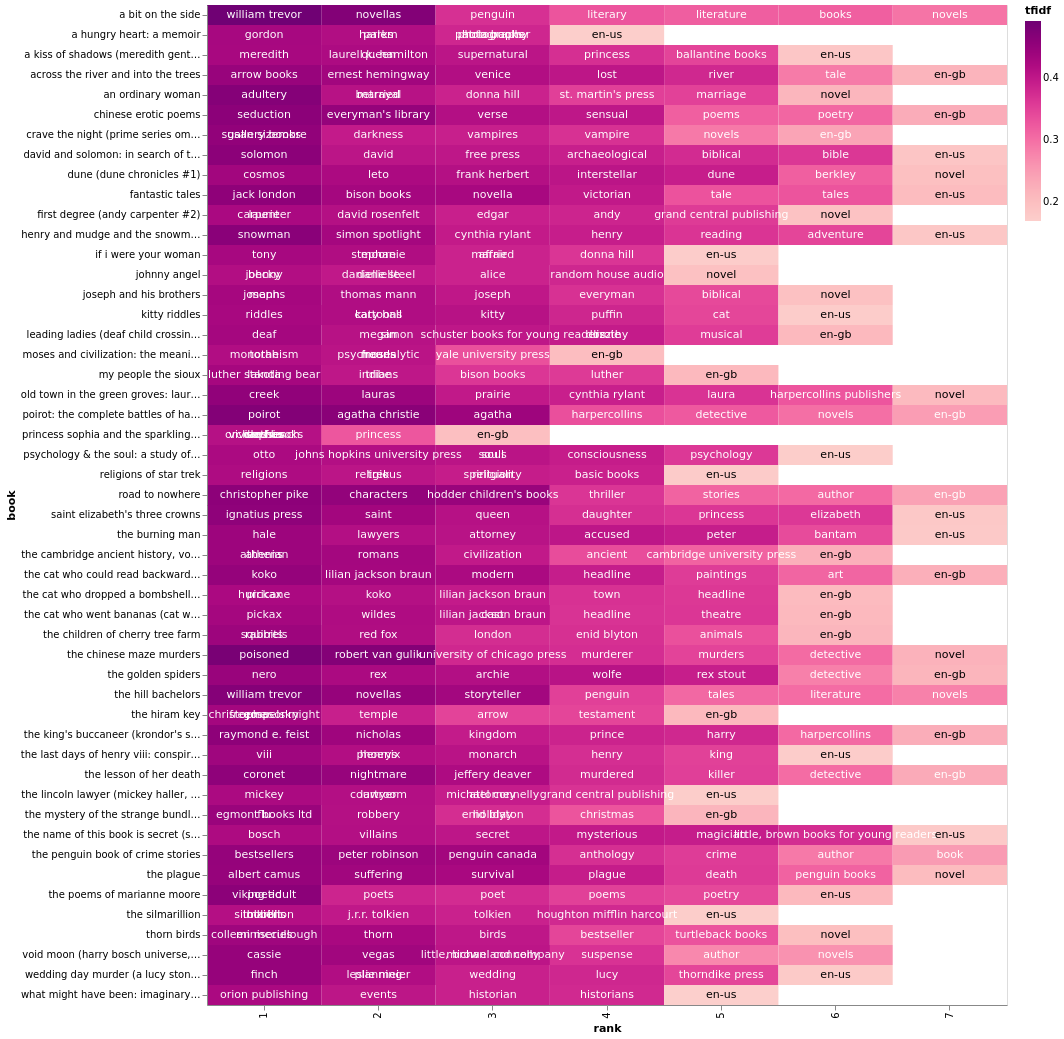

In [8]:
import altair as alt
grid = alt.Chart(tfidf_vec).encode(
    x = 'rank:O',
    y = 'book:N'
).transform_window(
    rank = "dense_rank()",
    sort = [alt.SortField("tfidf", order="descending")],
    groupby = ["book"],
)
heatmap = grid.mark_rect(size=5).encode(
    alt.Color('tfidf:Q', scale=alt.Scale(scheme='redpurple'))
)
text = grid.mark_text(align='center', baseline='middle', lineBreak='').encode(
    text = 'term:N',
    color = alt.condition(alt.datum.tfidf >= 0.23, alt.value('white'), alt.value('black'))
)
(heatmap+text).properties(width = 800)

---
---
# Cosine Similarity Between Books Vector Representation
Once the numerical vector representation of the data is created for each book, it becomes possible to apply all the techniques applicable in a geometric space. It is possible to find similarity between two vectors (and thereby between books represented as vectors). Cosine similarity is a measure that can find if two vectors in a multidimensional space are pointing in the same direction. It finds the cosine of the angle between the two vectors; smaller the angle higher is the cosine value. If the vectors are perpendicular the cosine similarity becomes zero  signifying the dissimilarity between the vectors.

In [43]:
book_cosine_sim = cosine_similarity(tfidf_encoding, tfidf_encoding)

Each row and column in the similarity matrix represents a book and contains cosine similarity values between them. Diagonal values would be 1 ($\cos(0)$) because a book will have absolute similarity with itself. The similarity matrix generated is sparse so we will use _spy_ to visualise the non-zero elements. All the blue markers in the image below are non-zero values. Books in the indices ranging in 1800-2000 have similarity with very few books. 

In [44]:
# Preview Similarity Matrix
book_cosine_sim

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

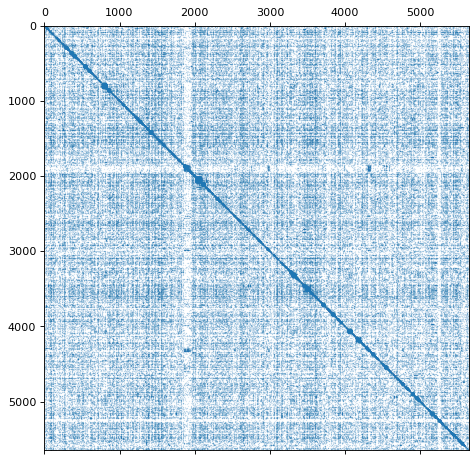

In [47]:
# Vidualize similarity between books
plt.figure(figsize=(6, 6), dpi=80)
plt.spy(book_cosine_sim, precision = 0.1, markersize = 0.04)
plt.tight_layout()
plt.show()

---
---
# Recommendation
Purpose is: given a book name, find top `n` similar books based on cosine similarity score. In real use cases, the input book could be the book a user has read, has rated highly or have added to the read later list.
Books are recommended utilising the following information through keywords:

In [48]:
books = pd.Series(model_data['Name'])

def recommend_books_similar_to(book_name, n=5, cosine_sim_mat=book_cosine_sim):
    # get index of the imput book
    input_idx = books[books == book_name].index[0]   
    # Find top n similar books with decreasing order of similarity score
    top_n_books_idx = list(pd.Series(cosine_sim_mat[input_idx]).sort_values(ascending = False).iloc[1:n+1].index)
    # [1:6] to exclude 0 (index 0 is the input movie itself)
    
    books_list = list(books)
    recommended_books = [books[i] for i in top_n_books_idx]
        
    return recommended_books

## 1. Series Information
- Suggest other books from the similar series.
- In the example, series information **images of america** is used to recommend books relating to different parts of America from the same series (new jersey). As the background of the given book is set in chicago, another book based on chicago is (**altgeld's america**) is suggested. Book **cell** is recommended because the protagonist of the book is in Boston (from the Description).   

In [49]:
# Recommendations with series information
print("\033[1m{}\033[0m".format("Recommendation (Series Information) based on the read: The Eastland Disaster (Images of America: Illinois)"))
display(recommend_books_similar_to("the eastland disaster (images of america: illinois)", 5))

Recommendation (Series Information) based on the read: The Eastland Disaster (Images of America: Illinois)


['forgotten chicago (images of america: illinois)',
 'trenton (images of america: new jersey)',
 "altgeld's america",
 'cell',
 'magnificent but not war: the battle of ypres, 1915']

## 2. Other Books In Numbered Series
- Suggest other books in the sequence from the same series.
- In the example below, other books in the series sequence of **Antique Lover** are recommended.

In [50]:
# Recommendations with series information numbered
print("\n\033[1m{}\033[0m".format("Recommendation (Numbered Series) based on the read: The Majolica Murders (Antique Lover, #5)"))
display(recommend_books_similar_to("the majolica murders (antique lover, #5)", 5))


Recommendation (Numbered Series) based on the read: The Majolica Murders (Antique Lover, #5)


['four on the floor (antique lover, #4)',
 'the weedless widow (antique lover, #2)',
 'the marriage casket (antique lover, #3)',
 'the body in the bookcase (faith fairchild, #9)',
 'out of control (mcclouds & friends #3)']

## 3.Theme
- Utilise keywords depicting semantic meaning of the theme of the book to suggest books from similar themes. 
- In the example below, all the books about developing programming skills irrespective of programming language are recommended.

In [51]:
print("\n\033[1m{}\033[0m".format("Recommendation (Theme: Programming) based on the read: The Practice of Programming (Addison-Wesley Professional Computing Series)"))
display(recommend_books_similar_to('the practice of programming (addison-wesley professional computing series)', 5))


Recommendation (Theme: Programming) based on the read: The Practice of Programming (Addison-Wesley Professional Computing Series)


['data structures & other objects using java',
 'the reasoned schemer',
 'simply scheme: a methods handbook',
 'nlp solutions: how to model what works in business and make it work for you',
 'java in a nutshell (in a nutshell)']

## 4. Author
- Suggest other works of the same Author.

In [52]:
print("\n\033[1m{}\033[0m".format("Recommendation (Author: Dean Koontz) based on the read: Cold Fire"))
display(recommend_books_similar_to("cold fire",5))


Recommendation (Author: Dean Koontz) based on the read: Cold Fire


['false memory',
 'the door to december',
 'darkfall',
 'forever odd (odd thomas, #2)',
 'whispers']

---
---
# Improvements
- Currently I have only used a keyword extraction method to tokenize the document. Instead of this some text preprocessing techniques such as Lemmatization and parts Of Speech Tagging can be applied before tokenizing the document. This will enhance the semantic interpretation of the words. 
- Keywords relating to the genre of the book could be included in the concise list of keywords to improve the results. 

# References
- [Goodreads Book Datasets With User Rating 2M, n.d.](https://www.kaggle.com/datasets/bahramjannesarr/goodreads-book-datasets-10m?select=book1000k-1100k.csv)
- [GitHub - MaartenGr/KeyBERT: Minimal keyword extraction with BERT, n.d.](https://github.com/MaartenGr/KeyBERT)
- [GitHub - emonson/altair-vis-python: Visualization in Altair with Python workshop, n.d.](https://github.com/emonson/altair-vis-python)